# Sliding Window Cross Validation 
## Define fixed Dataset K_fold split for each trial: 

In [1]:
import sys
import os

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_model_on_k_fold_validation import load_configuration
from K_fold_validation.K_fold_validation import KFoldSplitter
import numpy as np 
trial_id = 'subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
args,_ = load_configuration(trial_id,load_config=True)

# Configuration of K-fold Splitting :
args.validation_split_method = 'forward_chaining_cv' #'forward_chaining_cv'
args.min_fold_size_proportion = 0.75
args.train_prop = 0.6
args.valid_prop = 0.2
args.test_prop = 1 - args.train_prop - args.valid_prop
args.data_augmentation = False
# ...

folds = list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,args = K_fold_splitter.split_k_fold()

Training and Hyper-parameter tuning with Ray is not possible

>>>> Load best CONFIG
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([5069, 40]) with 202760 Total nb of elements and 0 Nan values
Init 

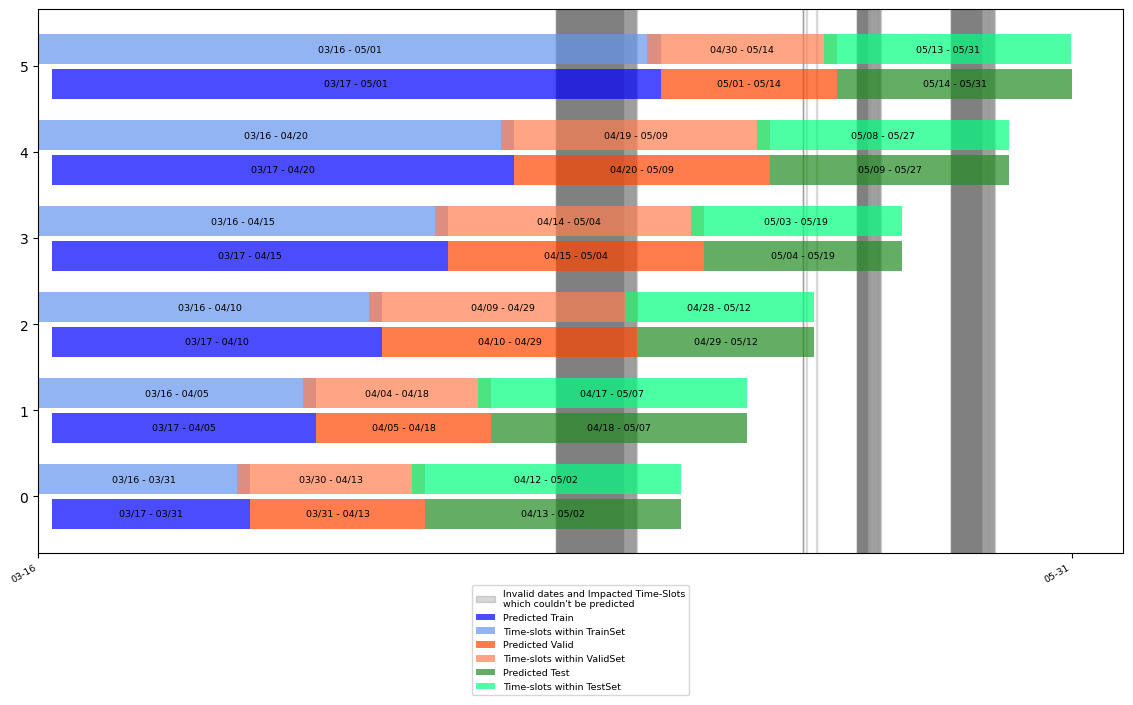

In [2]:
from plotting.plotting import plot_k_fold_split
plot_k_fold_split(K_subway_ds,K_subway_ds[0].init_invalid_dates,figsize=(14,8))

## Check Number of predicted day in validation set: 

In [ ]:
for i in range(args.K_fold):
    dset = K_subway_ds[i]
    limits = dset.tensor_limits_keeper
    display(limits.df_verif_valid['t+0'].dt.date.value_counts())

## Split Tuning and Validation datasets:

In [4]:
ds_tuning = K_subway_ds[0]
ds_validation = K_subway_ds[1:]

## Train on the K-1 folds:

In [5]:
valid_losses = []
for fold,ds in enumerate(ds_validation):
    model = load_model(args,dic_class2rpz)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,dic_class2rpz = dic_class2rpz,show_figure = False,fold=fold,save_folder = save_folder)
    trainer.train_and_valid(mod = 1000,mod_plot = None) 
    valid_losses.append(trainer.performance['valid_loss'])

## Save Model: 
row = {f"fold{k}": [loss] for k,loss in enumerate(valid_losses)}
row.update({'mean' : [np.mean(valid_losses)]})
df_results = pd.DataFrame.from_dict(row)
df_results.to_csv(f"{SAVE_DIRECTORY}/{save_folder}/VALID_{trial_id}.csv")

Model size: 0.000GB
number of total parameters: 4
number of trainable parameters: 4

start training


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 0 
 min\epoch : 0.02
Estimated time for training: 0.1min 
Training Throughput:3278.27 sequences per seconds
>>> Training complete in: 0:00:08.614024
>>> Training performance time: min 0.008652687072753906 avg 0.009569168090820312 seconds (+/- 0.0002687663403319963)
>>> Loading performance time: min 0.0001418590545654297 avg 0.006269339232416878 seconds (+/- 0.016083101341490737)
>>> Forward performance time: 0.004888151460965006 seconds (+/- 0.0001794107955518619)
>>> Backward performance time: 0.004706347638272045 seconds (+/- 0.00015803939227106628)
>>> Plotting performance time: 1.0251998901367188e-05 seconds (+/- 2.327076070266357e-05)
>>> Saving performance time: 0.0016219615936279297 seconds (+/- 5.058723139040159e-05)
>>> PI-tracking performance time: 2.3312038845486113e-06 seconds (+/- 5.123106534166791e-07)
>>> Scheduler-update performance time: 3.96569569905599e-05 seconds (+/- 7.273395022486084e-06)
>>> Validation time: 0:00:00.166119
Proportion of time consumed for L